<a href="https://colab.research.google.com/github/MLSBHARGAVASAI/SCT_ML_1/blob/main/SCT_ML_1_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 🏡 SCT_ML_1 – House Price Prediction (Linear Regression)

# ==========================================
# STEP 1: Setup & Extract Dataset from ZIP
# ==========================================
import zipfile
import os

# 🔹 Replace this with your actual zip file path
zip_path = "/content/house-prices-advanced-regression-techniques.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Check extracted files
os.listdir("/content/dataset")


['train.csv', 'test.csv', 'data_description.txt', 'sample_submission.csv']

In [4]:
# ==========================================
# STEP 2: Import Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [5]:
# ==========================================
# STEP 3: Load Data
# ==========================================
train = pd.read_csv("/content/dataset/train.csv")
test = pd.read_csv("/content/dataset/test.csv")
sample_submission = pd.read_csv("/content/dataset/sample_submission.csv")

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

train.head()


Train Shape: (1460, 81)
Test Shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


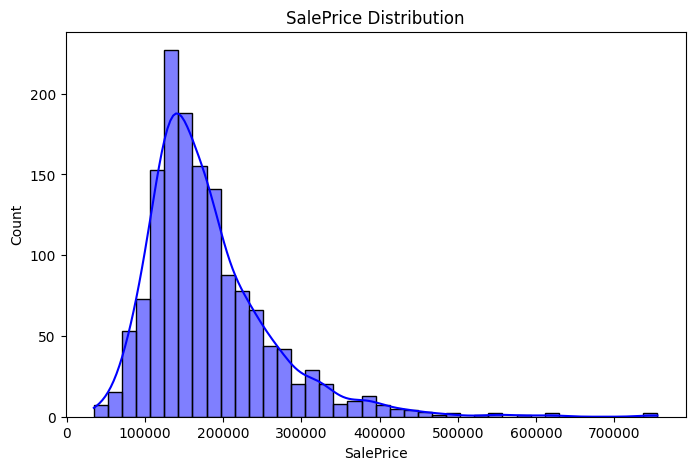

/tmp/ipython-input-1921514651.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="viridis")


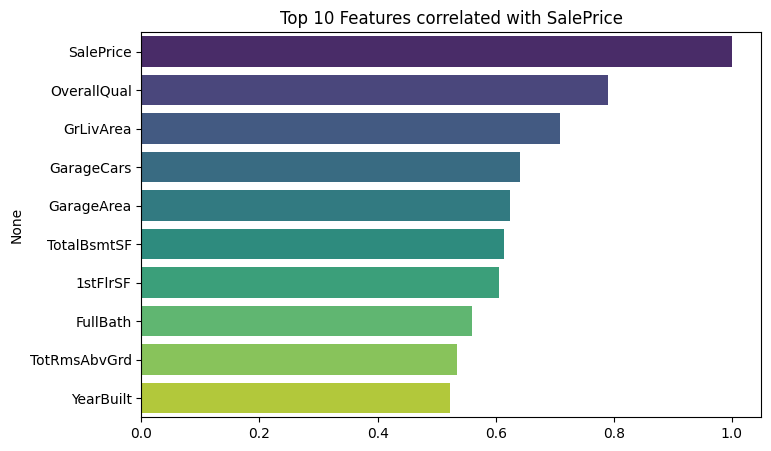

In [6]:
# ==========================================
# STEP 4: Quick EDA
# ==========================================
# Distribution of SalePrice
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'], bins=40, kde=True, color="blue")
plt.title("SalePrice Distribution")
plt.show()

# Correlation with SalePrice (top 10)
corr = train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=corr.values, y=corr.index, palette="viridis")
plt.title("Top 10 Features correlated with SalePrice")
plt.show()


In [7]:
# ==========================================
# STEP 5: Preprocessing
# ==========================================
y = train['SalePrice']

X = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop(['Id'], axis=1)

# Fill missing values
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].fillna(X[col].mode()[0])
        X_test[col] = X_test[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())
        X_test[col] = X_test[col].fillna(X[col].median())

# One-hot encode categorical variables
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

# Align columns
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

print("Processed Train Shape:", X.shape)
print("Processed Test Shape:", X_test.shape)


Processed Train Shape: (1460, 287)
Processed Test Shape: (1459, 287)


In [8]:
# ==========================================
# STEP 6: Train-Test Split & Scaling
# ==========================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [9]:
# ==========================================
# STEP 7: Train Linear Regression Model
# ==========================================
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_val_scaled)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)


Validation RMSE: 28475.687090432482
Validation R²: 0.8942854927718146


In [10]:
# ==========================================
# STEP 8: Cross-Validation
# ==========================================
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring="r2")
print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))


Cross-validation R² scores: [0.87324696 0.73123012 0.67956029 0.70392191 0.8286325 ]
Mean CV R²: 0.7633183551387542


In [11]:
# ==========================================
# STEP 9: Train on Full Data & Predict Test
# ==========================================
lr.fit(scaler.fit_transform(X), y)
test_preds = lr.predict(X_test_scaled)

submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": test_preds
})
submission.to_csv("/content/submission.csv", index=False)

print("✅ submission.csv file created at /content/")
submission.head()


✅ submission.csv file created at /content/


,Id,SalePrice
0,1461,111974.585660
1,1462,153804.915186
2,1463,185559.592340
3,1464,199785.705218
4,1465,201730.763073


/tmp/ipython-input-1043850112.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.head(15), x="Coefficient", y="Feature", palette="coolwarm")


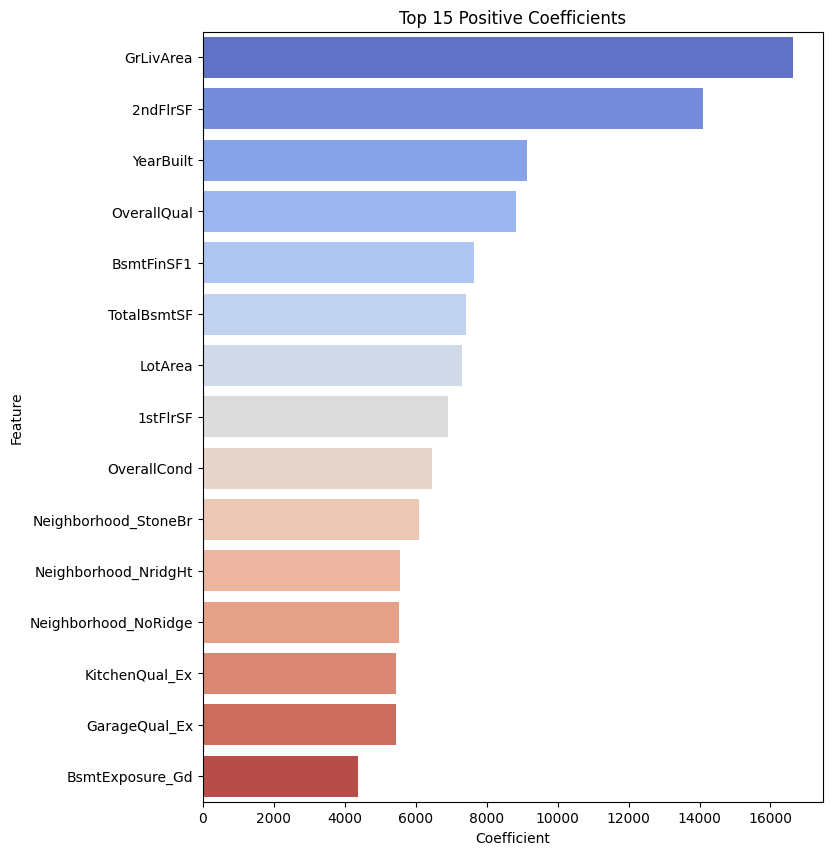

/tmp/ipython-input-1043850112.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df.tail(15), x="Coefficient", y="Feature", palette="coolwarm")


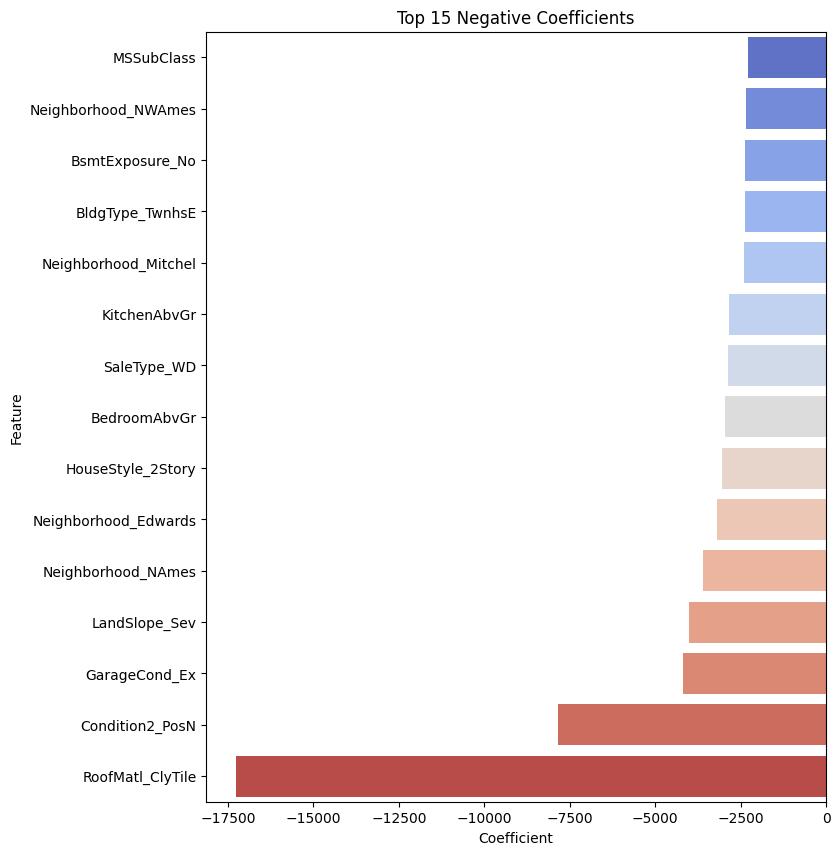

In [12]:
# ==========================================
# STEP 10: Feature Importance (Linear Regression Coefficients)
# ==========================================
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=coef_df.head(15), x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Top 15 Positive Coefficients")
plt.show()

plt.figure(figsize=(8,10))
sns.barplot(data=coef_df.tail(15), x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Top 15 Negative Coefficients")
plt.show()
